<a href="https://colab.research.google.com/github/masatoran/DaconDefaultCompetiton/blob/master/DaconVer4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y keras tensorflow tensorflow-estimator

Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0


In [ ]:
!pip install --upgrade tensorflow

  Using cached tensorflow-2.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached keras-3.8.0-py3-none-any.whl.metadata (5.8 kB)
Using cached tensorflow-2.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (615.4 MB)
Using cached keras-3.8.0-py3-none-any.whl (1.3 MB)


In [1]:
import tensorflow as tf
print(tf.__version__)  # TensorFlowのバージョンを確認
print(tf.keras.__version__)  # Kerasのバージョンを確認

2.18.0
3.8.0


In [2]:
from tensorflow import keras
print(keras.__version__)

3.8.0


In [3]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 처리
import pandas as pd
import numpy as np

# 데이터 전처리
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold

# 불균형 데이터 처리
from imblearn.over_sampling import SMOTE

# 모델 평가
from sklearn.metrics import roc_auc_score

# 딥러닝 모델 (TensorFlow)
#import tensorflow as tf
#import tensorflow.keras as keras

import matplotlib.pyplot as plt

In [4]:
# TensorFlow GPU 가속 확인
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ GPU 가속 활성화됨!")
else:
    print("⚠️ GPU를 감지할 수 없습니다. CPU에서 실행됩니다.")

✅ GPU 가속 활성화됨!


1. 데이터 로드 및 UID 처리

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/DaconCompe/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DaconCompe/test.csv')

In [6]:
# "UID" 컬럼 유지 (제출 파일용)
test_uid = test_df[["UID"]]

# "UID" 컬럼 삭제
train_df.drop(columns=["UID"], inplace=True)
test_df.drop(columns=["UID"], inplace=True)

# X, y 분리
X = train_df.drop(columns=["채무 불이행 여부"])
y = train_df["채무 불이행 여부"]

2. 범주형 변수 처리 (라벨 인코딩 & 원-핫 인코딩)

In [7]:
categorical_cols = ["주거 형태", "현재 직장 근속 연수", "대출 목적", "대출 상환 기간"]

# 라벨 인코딩 (현재 직장 근속 연수)
label_enc = LabelEncoder()
X["현재 직장 근속 연수"] = label_enc.fit_transform(X["현재 직장 근속 연수"])
test_df["현재 직장 근속 연수"] = label_enc.transform(test_df["현재 직장 근속 연수"])

# 원-핫 인코딩 적용
X = pd.get_dummies(X, columns=["주거 형태", "대출 목적", "대출 상환 기간"], drop_first=True)
test_df = pd.get_dummies(test_df, columns=["주거 형태", "대출 목적", "대출 상환 기간"], drop_first=True)

3. 수치형 변수 변환 (로그 변환 적용)

In [8]:
# 로그 변환
log_columns = ["현재 미상환 신용액", "월 상환 부채액", "현재 대출 잔액"]
for col in log_columns:
    X[col] = np.log1p(X[col])
    test_df[col] = np.log1p(test_df[col])

# "마지막 연체 이후 경과 개월 수"가 0이면 "연체 없음" 컬럼 추가
X["연체 없음"] = (X["마지막 연체 이후 경과 개월 수"] == 0).astype(int)
test_df["연체 없음"] = (test_df["마지막 연체 이후 경과 개월 수"] == 0).astype(int)

4. 결측값 처리

In [9]:
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
test_imputed = imputer.transform(test_df)

5. 데이터 스케일링 (StandardScaler 적용)

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
test_scaled = scaler.transform(test_imputed)

6. 불균형 데이터 처리 (SMOTE 적용)

In [11]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

 7. 딥러닝 모델 정의 / 학습 / 평가

🔄 Fold 1 시작
Epoch 1/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.4757 - loss: 0.7281 - val_accuracy: 0.4799 - val_loss: 0.7000
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4881 - loss: 0.7132 - val_accuracy: 0.5057 - val_loss: 0.6926
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5075 - loss: 0.7039 - val_accuracy: 0.5231 - val_loss: 0.6872
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5115 - loss: 0.6997 - val_accuracy: 0.5402 - val_loss: 0.6829
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5320 - loss: 0.6932 - val_accuracy: 0.5520 - val_loss: 0.6788
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5388 - loss: 0.6904 - val_accuracy: 0.5664 - val_loss: 0.6753
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5531 - loss: 0.6851 - val_accuracy: 0.5804 - val_loss: 0.6718
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5559 - loss: 0.68

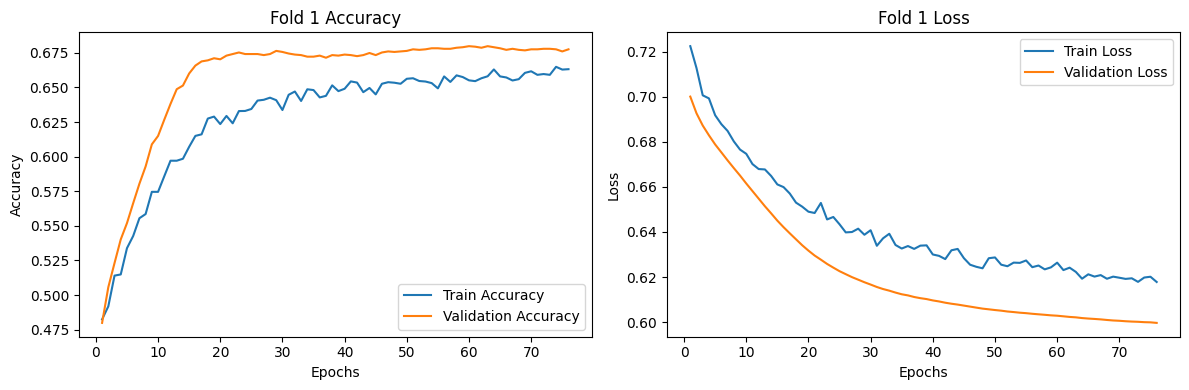

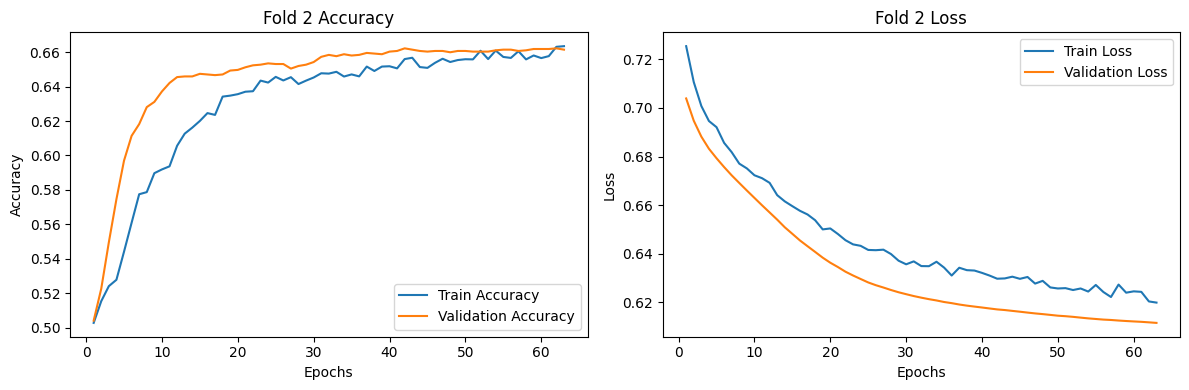

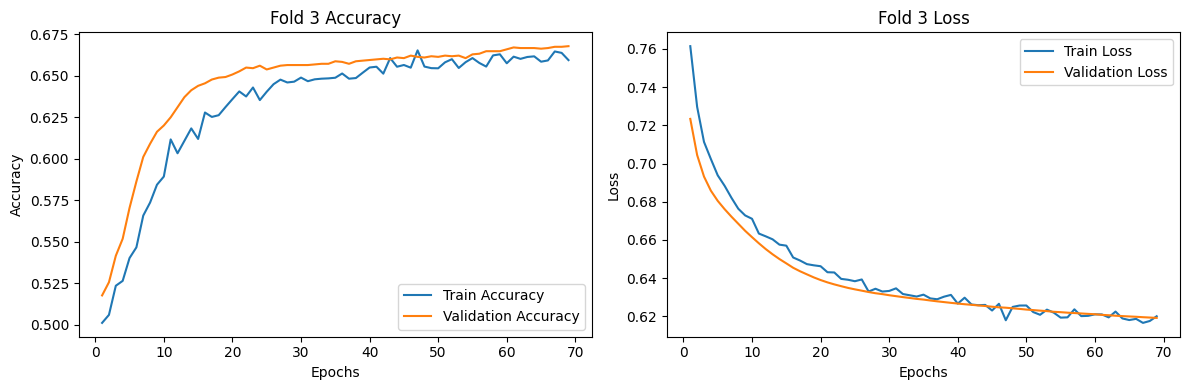

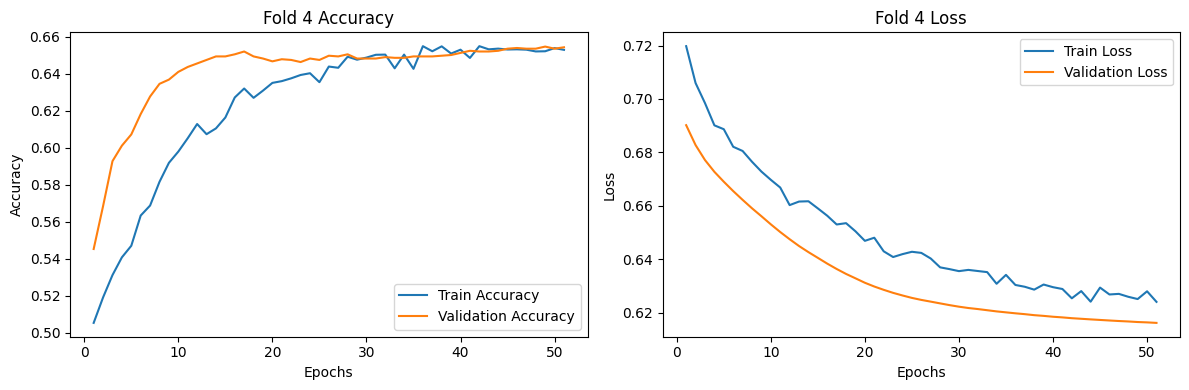

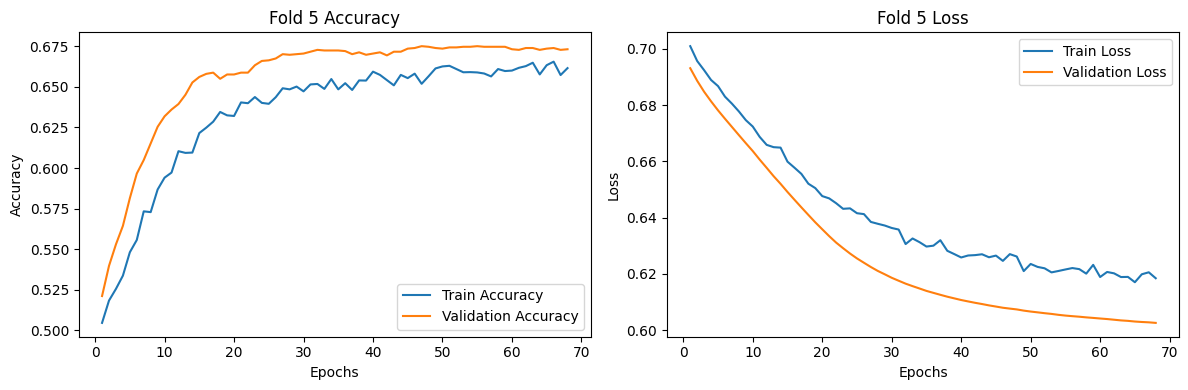

In [12]:
# Fold별 Accuracy와 Loss 저장용 리스트 초기화
all_history = []  # 이 줄을 추가하여 all_history를 명확히 초기화합니다.

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
roc_auc_scores = []

for train_index, valid_index in kf.split(X_resampled):
    print(f"🔄 Fold {fold} 시작")

    # 학습/검증 데이터 분리
    X_train_fold, X_valid_fold = X_resampled[train_index], X_resampled[valid_index]
    y_train_fold, y_valid_fold = y_resampled[train_index], y_resampled[valid_index]

    # 모델 정의
    model = keras.Sequential([
        keras.layers.Dense(128, activation="relu", input_shape=(X_train_fold.shape[1],)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")
    ])

    # 모델 컴파일
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    # 조기 종료 콜백 설정
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=0.001,
        restore_best_weights=True
    )

    # 모델 학습
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_valid_fold, y_valid_fold),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    # Fold의 학습 결과 저장
    all_history.append(history.history)  # Fold별 학습 결과 저장

    # 검증 데이터 예측 및 평가
    y_valid_pred = model.predict(X_valid_fold).flatten()
    roc_auc = roc_auc_score(y_valid_fold, y_valid_pred)
    print(f"Fold {fold} Validation ROC-AUC: {roc_auc:.4f}")
    roc_auc_scores.append(roc_auc)
    fold += 1

# 교차검증 평균 결과 출력
print(f"✅ 교차검증 평균 ROC-AUC: {np.mean(roc_auc_scores):.4f}")

# 시각화: Fold별 Accuracy와 Loss
for i, history in enumerate(all_history):
    epochs = range(1, len(history['loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy 시각화
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {i + 1} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss 시각화
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {i + 1} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [14]:
y_test_pred = model.predict(test_scaled).flatten()  # 확률 값 그대로 사용

# 제출 파일 생성
submission = pd.DataFrame({
    "UID": test_uid["UID"],
    "채무 불이행 확률": y_test_pred  # 확률값을 그대로 저장
})

# CSV 저장
submission.to_csv("/content/drive/MyDrive/DaconCompe/submission/submission_2.csv", index=False)

print("✅ 제출 파일 생성 완료! 저장되었습니다.")

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ 제출 파일 생성 완료! 저장되었습니다.
